In [1]:
import sys
import time
import datetime
import os
import tensorflow as tf
import argparse
import json
import socket
from PIL import Image
from util import *
import numpy as np
%load_ext autoreload
%autoreload 2
from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib.colors import hsv_to_rgb
%matplotlib inline
from helpers import *
from datetime import datetime
from scipy.ndimage import imread
import warnings
warnings.filterwarnings('ignore')
from scipy.ndimage.filters import convolve as filter2
from scipy.io import loadmat

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
logPath = "training/"

with open("hyperParams.json") as f:
    instanceParams = json.load(f)

printFrequency = instanceParams["printFreq"]
batchSize = 1#instanceParams["batchSize"]

iterations = instanceParams["iterations"]
baseLearningRate = instanceParams["baseLR"]
learningRate = baseLearningRate
snapshotFrequency = instanceParams["snapshotFreq"]

photoAlpha = instanceParams["photoParams"]["robustness"]
photoBeta = instanceParams["photoParams"]["scale"]
wei = instanceParams["smoothParams"]["weight"]

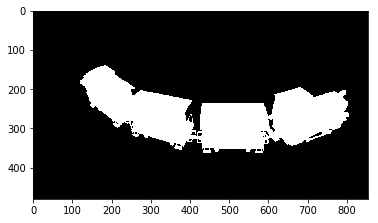

In [3]:
gt = mpimg.imread("../example_data/data/DAVIS/Annotations/480p/train/00023.png")
plt.imshow(gt, cmap='gray')

In [4]:
flow = np.zeros((480, 854, 2))
flow = np.expand_dims(flow, 0)

In [5]:
gt = np.expand_dims(np.expand_dims(gt, 0), -1)

In [6]:
flow = tf.cast(flow, tf.float32)
gt = tf.cast(gt, tf.float32)
flow = tf.Variable(flow)

In [7]:
rgb0 = tf.image.decode_png(
    tf.read_file(
        "../example_data/data/DAVIS/JPEGImages/480p/train/00023.jpg"), channels=3, dtype=tf.uint8)
rgb1 = tf.image.decode_png(
    tf.read_file(
        "../example_data/data/DAVIS/JPEGImages/480p/train/00024.jpg"), channels=3, dtype=tf.uint8)

# rgb0 = tf.image.rgb_to_grayscale(rgb0)
# rgb1 = tf.image.rgb_to_grayscale(rgb1)

rgb0 = tf.cast(rgb0, tf.float32) - [[[[0,0,0]]]]
rgb1 = tf.cast(rgb1, tf.float32) - [[[[0,0,0]]]]

In [8]:
def compute_photo_gradient(rgb0, rgb1, flow):
    warpIm = flowWarp(rgb1, flow)
    kernelY = tf.transpose(tf.constant([\
        [ \
            [ \
                [-1, 9, -45, 0, 45, -9, 1]
            ] \
        ]
    ],dtype=tf.float32),perm=[3,2,1,0])
    kernelX = tf.transpose(tf.constant([\
        [ \
            [ \
                [-1], [9], [-45], [0], [45], [-9], [1]
            ] \
        ]
    ],dtype=tf.float32),perm=[3,2,1,0])
    kernelY = kernelY / 60.0
    kernelX = kernelX / 60.0

    Ix = tf.concat([
        tf.nn.conv2d(tf.expand_dims(warpIm[:,:,:,i], axis=-1), kernelX, [1,1,1,1], padding='SAME')
        for i in range(3)
    ], axis=-1)
    Iy = tf.concat([
        tf.nn.conv2d(tf.expand_dims(warpIm[:,:,:,i], axis=-1), kernelY, [1,1,1,1], padding='SAME')
        for i in range(3)
    ], axis=-1)

    diff = 2 * (warpIm - rgb0)
    return tf.stack([tf.reduce_mean(diff * Ix, axis=-1), tf.reduce_mean(diff * Iy, axis=-1)], axis=-1)

In [9]:
kernel = tf.transpose(tf.constant([[[[0,-1,0],
                                     [0,1,0],
                                     [0,0,0]]],
                                   [[[0,0,0],
                                     [0,1,-1],
                                     [0,0,0]]],
                                   [[[0,0,0],
                                     [0,1,0],
                                     [0,-1,0]]],
                                   [[[0,0,0],
                                     [-1,1,0],
                                     [0,0,0]]]],
                                  dtype=tf.float32),perm=[3,2,1,0])

w = 1
GT_MASKS = []
for i in range(w):
    GT_MASKS.append(1 - tf.square(tf.nn.atrous_conv2d(gt, kernel, rate=i+1, padding='SAME')))

In [10]:
normalizer = tf.zeros((1, 480, 854, 2))

multiplier_masks = []
for i in range(w):
    multiplier_masks.append([])

for i in range(w):
    j = i + 1
    gt_mask = GT_MASKS[i]

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([gt_mask[:,:,j:854,0],
                           tf.zeros((1, 480, j), dtype=tf.float32)], axis=2), axis=-1), (1, 1, 1, 2)))

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([tf.zeros((1, j, 854), dtype=tf.float32),
                           gt_mask[:,0:(480-j),:,1]], axis=1), axis=-1), (1, 1, 1, 2)))

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([tf.zeros((1, 480, j), dtype=tf.float32),
                           gt_mask[:,:,0:(854-j),2]], axis=2), axis=-1), (1, 1, 1, 2)))

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([gt_mask[:,j:480,:,3],
                           tf.zeros((1, j, 854), dtype=tf.float32)], axis=1), axis=-1), (1, 1, 1, 2)))

    normalizer += multiplier_masks[i][0] + multiplier_masks[i][1] + multiplier_masks[i][2] + multiplier_masks[i][3]

# Remove 0's in normalizer
normalizer += 4 * w * tf.cast(tf.equal(normalizer, 0), dtype=tf.float32)
normalizer.shape

TensorShape([Dimension(1), Dimension(480), Dimension(854), Dimension(2)])

In [11]:
def compute_smooth_gradient(gt, flow):
    temp = tf.zeros_like(flow)
    for i in range(w):
        j = i + 1
        temp += tf.concat([flow[:,:,j:854,:],
                           tf.zeros((1, 480, j, 2), dtype=tf.float32)], axis=2) * multiplier_masks[i][0]

        temp += tf.concat([tf.zeros((1, j, 854, 2), dtype=tf.float32),
                           flow[:,0:(480-j),:,:]], axis=1) * multiplier_masks[i][1]

        temp += tf.concat([tf.zeros((1, 480, j, 2), dtype=tf.float32),
                           flow[:,:,0:(854-j),:]], axis=2) * multiplier_masks[i][2]

        temp += tf.concat([flow[:,j:480,:,:],
                           tf.zeros((1, j, 854, 2), dtype=tf.float32)], axis=1) * multiplier_masks[i][3]

    return 2 * (flow - temp / normalizer)

In [12]:
lambda_ = 10000
total_gradient = compute_photo_gradient(rgb0, rgb1, flow) + lambda_ * compute_smooth_gradient(gt, flow)

In [13]:
lr = 1e-5
new_flow = flow.assign(flow - lr * total_gradient)
itr = 5000

In [14]:
pLoss = photoLoss(flow, rgb0, rgb1, photoAlpha, photoBeta)
sLoss = asymmetricSmoothLoss(flow, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [15]:
init = tf.global_variables_initializer()
sLosses = []
pLosses = []
flows = []
print_freq = 10
with tf.Session() as sess:
    sess.run(init)
    for i in range(1, itr + 2):
        p, s, f, tg = sess.run([pLoss, sLoss, new_flow, total_gradient])

        if i % print_freq == 1:
            print(i)
            pLosses.append(np.mean(p))
            sLosses.append(np.mean(s))
            flows.append(deepcopy(f[0]))
            print "Photo loss: %f" % float(pLosses[-1])
            print "Smooth loss: %f" % float(sLosses[-1])

1
Photo loss: 2895.463867
Smooth loss: 0.000004
11
Photo loss: 2279.592285
Smooth loss: 0.013964
21
Photo loss: 2081.687012
Smooth loss: 0.019136
31
Photo loss: 1951.863037
Smooth loss: 0.021746
41
Photo loss: 1854.813110
Smooth loss: 0.023412
51
Photo loss: 1777.306641
Smooth loss: 0.024609
61
Photo loss: 1713.463745
Smooth loss: 0.025517
71
Photo loss: 1659.511841
Smooth loss: 0.026220
81
Photo loss: 1613.427124
Smooth loss: 0.026798
91
Photo loss: 1573.280884
Smooth loss: 0.027280
101
Photo loss: 1537.624512
Smooth loss: 0.027673
111
Photo loss: 1505.858887
Smooth loss: 0.028001
121
Photo loss: 1476.900757
Smooth loss: 0.028279
131
Photo loss: 1450.187866
Smooth loss: 0.028513
141
Photo loss: 1425.505249
Smooth loss: 0.028711
151
Photo loss: 1402.567261
Smooth loss: 0.028881
161
Photo loss: 1380.914429
Smooth loss: 0.029031
171
Photo loss: 1360.447144
Smooth loss: 0.029163
181
Photo loss: 1340.922974
Smooth loss: 0.029280
191
Photo loss: 1322.291016
Smooth loss: 0.029381
201
Photo l

1681
Photo loss: 356.659393
Smooth loss: 0.016785
1691
Photo loss: 354.561279
Smooth loss: 0.016727
1701
Photo loss: 352.518280
Smooth loss: 0.016670
1711
Photo loss: 350.545166
Smooth loss: 0.016613
1721
Photo loss: 348.627472
Smooth loss: 0.016557
1731
Photo loss: 346.741730
Smooth loss: 0.016502
1741
Photo loss: 344.883514
Smooth loss: 0.016447
1751
Photo loss: 343.075104
Smooth loss: 0.016394
1761
Photo loss: 341.323761
Smooth loss: 0.016341
1771
Photo loss: 339.610352
Smooth loss: 0.016289
1781
Photo loss: 337.900787
Smooth loss: 0.016238
1791
Photo loss: 336.182404
Smooth loss: 0.016185
1801
Photo loss: 334.483398
Smooth loss: 0.016131
1811
Photo loss: 332.822845
Smooth loss: 0.016077
1821
Photo loss: 331.169830
Smooth loss: 0.016022
1831
Photo loss: 329.535919
Smooth loss: 0.015965
1841
Photo loss: 327.922089
Smooth loss: 0.015908
1851
Photo loss: 326.340057
Smooth loss: 0.015851
1861
Photo loss: 324.693024
Smooth loss: 0.015796
1871
Photo loss: 322.982758
Smooth loss: 0.015743


3321
Photo loss: 220.586319
Smooth loss: 0.011762
3331
Photo loss: 220.222977
Smooth loss: 0.011740
3341
Photo loss: 219.893066
Smooth loss: 0.011717
3351
Photo loss: 219.600983
Smooth loss: 0.011698
3361
Photo loss: 219.322891
Smooth loss: 0.011688
3371
Photo loss: 218.931213
Smooth loss: 0.011677
3381
Photo loss: 218.486023
Smooth loss: 0.011653
3391
Photo loss: 218.087692
Smooth loss: 0.011626
3401
Photo loss: 217.761902
Smooth loss: 0.011602
3411
Photo loss: 217.503265
Smooth loss: 0.011584
3421
Photo loss: 217.252563
Smooth loss: 0.011576
3431
Photo loss: 216.869919
Smooth loss: 0.011560
3441
Photo loss: 216.479156
Smooth loss: 0.011533
3451
Photo loss: 216.133453
Smooth loss: 0.011502
3461
Photo loss: 215.808319
Smooth loss: 0.011473
3471
Photo loss: 215.537964
Smooth loss: 0.011449
3481
Photo loss: 215.288986
Smooth loss: 0.011432
3491
Photo loss: 215.005341
Smooth loss: 0.011415
3501
Photo loss: 214.686050
Smooth loss: 0.011391
3511
Photo loss: 214.344849
Smooth loss: 0.011359


4961
Photo loss: 188.314957
Smooth loss: 0.009612
4971
Photo loss: 188.230255
Smooth loss: 0.009607
4981
Photo loss: 188.145432
Smooth loss: 0.009602
4991
Photo loss: 188.060928
Smooth loss: 0.009597
5001
Photo loss: 187.976700
Smooth loss: 0.009592


max flow: 12.9536
flow range:
u = -9.189 .. 8.075
v = -12.276 .. 7.860


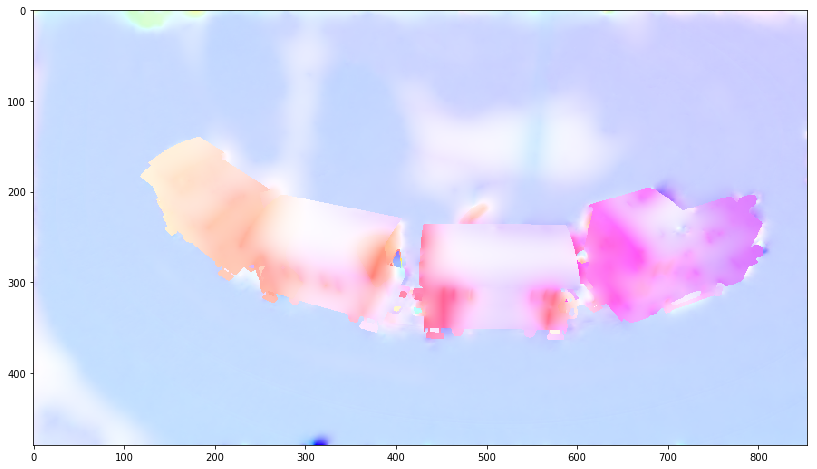

In [16]:
i = -1
plt.figure(figsize=(15, 8))
plt.imshow(flow_to_image(flows[-1]))

In [18]:
f = np.expand_dims(np.concatenate((U[i], V[i]), axis=-1), 0)
f = tf.cast(f, tf.float32)

In [19]:
pLoss = photoLoss(f, rgb0, rgb1, photoAlpha, photoBeta)
np.mean(pLoss.eval(session=tf.Session()))

425.5476